In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from casadi import *
%matplotlib notebook

In [2]:
def PoseToEulerTransform(pose):
    """
    Creates Euler Transformation from a given pose
    
    """
    
    y = pose[3]
    p = pose[4]
    r = pose[5]
    cy = np.cos(y)
    cp = np.cos(p)
    cr = np.cos(r)
    sy = np.sin(y)
    sp = np.sin(p)
    sr = np.sin(r)
    return np.array([
        [cp*cy, sr*sp*cy+cr*sy, -cr*sp*cy+sr*sy, pose[0]],
        [-cp*sy, -sr*sp*sy+cr*cy, cr*sp*sy+sr*cy, pose[1]],
        [sp, -sr*cp, cr*cp, pose[2]],
        [0, 0, 0, 1]
    ])

## Creating data by simulation

<IPython.core.display.Javascript object>


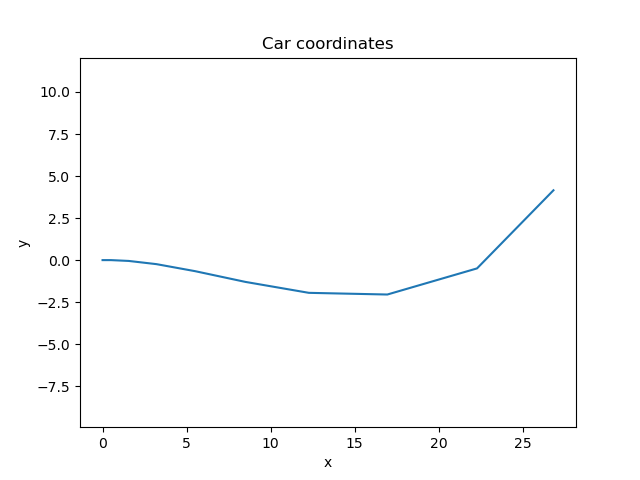

<IPython.core.display.Javascript object>


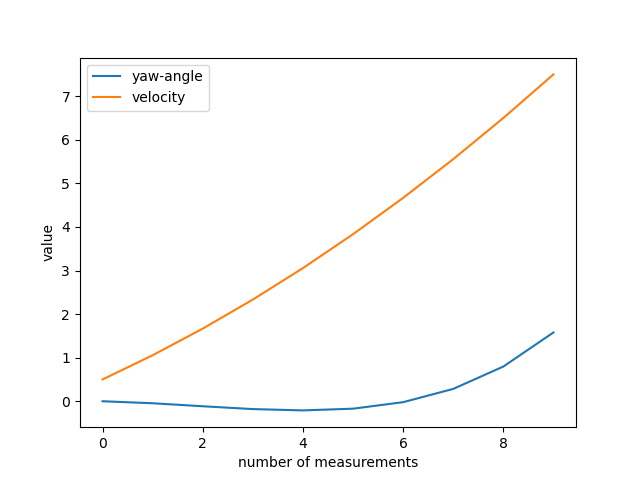

In [3]:
# Using Euler Transformations
# Sensor pose Ground-Truth
Ps1 = np.array([1, 2, 0, np.pi/2, 0, 0]) # [x, y, z, yaw, pitch, roll]
# Sensor pose to euler transform
Ts1 = PoseToEulerTransform(Ps1)

# Total simulation time
T = 10
dt = 1
steps = int(T/dt)

# Simulate car
def motion_model(x, u, dt):
    new_x = copy.deepcopy(x)
    
    new_x[0] = x[0] + x[3] * np.cos(x[2]) * dt
    new_x[1] = x[1] + x[3] * np.sin(x[2]) * dt
    new_x[2] = x[2] + x[3] * (np.tan(u[1])/2.7) * dt
    new_x[3] = x[3] + u[0] * dt

    return new_x

# Inital state
x = np.array([
    [0.0],
    [0.0],
    [0.0],
    [0.0]
])

# Control sequence
U = np.zeros((steps, 2), np.float)
U[:, 0] = np.linspace(0.5, 1, steps)
U[:, 1] = np.linspace(-np.pi/10, np.pi/10, steps)

car_states = []
for i in range(steps):
    x = motion_model(x, U[i, :], dt)
    car_states.append(x)
    
car_states = np.squeeze(np.array(car_states))
    
# Plotting
plt.figure()
plt.title("Car coordinates")
plt.plot(car_states[:, 0], car_states[:, 1])
plt.axis("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.figure()
plt.plot(car_states[:, 2], label="yaw-angle")
plt.plot(car_states[:, 3], label="velocity")
plt.xlabel("number of measurements")
plt.ylabel("value")
plt.legend(loc="best")
plt.show()

Finding what the sensor should according to the ground-truth pose, and then adding cummulative noise to it

<IPython.core.display.Javascript object>


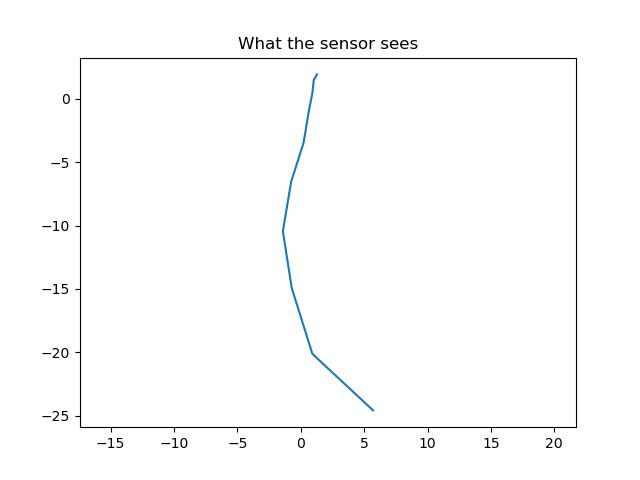

(-1.768528728151474,
 6.0639414176996675,
 -25.907583803589738,
 3.253772628306855)

In [4]:
# Points to match after the sensor transform
pts = copy.deepcopy(car_states)
pts[:,2] = 0
pts[:,3] = 1
sensor_states = pts@Ts1.T
# Adding noise to sensor odometry
sensor_states[:,:2] += np.cumsum(np.random.normal(0, 0.25, (steps, 2)), axis=0)

# Plotting
plt.figure()
plt.title("What the sensor sees")
plt.plot(sensor_states[:, 0], sensor_states[:, 1])
plt.axis("equal")

## Optimizing for pose
Forming a non-linear optimization problem to solve for pose

In [5]:
opti = Opti()

# Working backwards to find the sensor pose
Ps1G = opti.variable(6) # Pose variable to tune
Ts1G = PoseToEulerTransform(Ps1G)

reverse = pts@Ts1G.T

loss_x = reverse[:,0] - sensor_states[:,0]
loss_y = reverse[:,1] - sensor_states[:,1]
loss_x = loss_x.T@np.eye(loss_x.shape[0])@loss_x
loss_y = loss_y.T@np.eye(loss_y.shape[0])@loss_y
loss = loss_x + loss_y

# Specifying initial expected pose
opti.set_initial(Ps1G, [0, 0, 0, 0, 0, 0])
    
# ---- objective ---------
opti.minimize(loss)

# ---- solve NLP ------
opti.solver("ipopt") # set numerical backend
sol = opti.solve()   # actual solve


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       14

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

Pose Ground-truth: [1.         2.         0.         1.57079633 0.         0.        ]
Pose Estimated   : [0.85359926 2.05223119 0.         1.55154776 0.         0.        ]


<IPython.core.display.Javascript object>


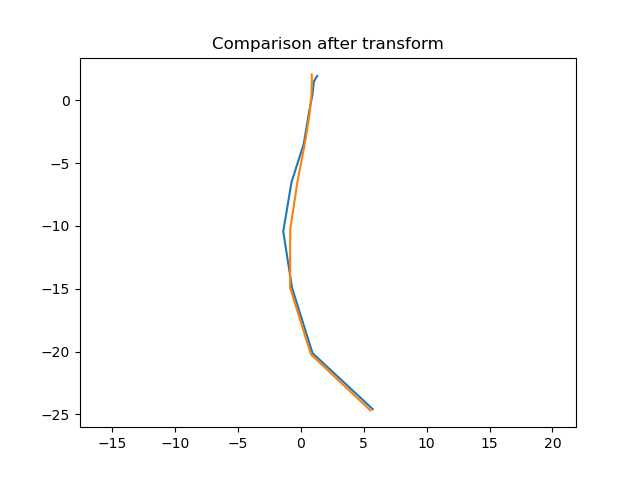

(-1.768528728151474,
 6.0639414176996675,
 -26.016316167015912,
 3.3888286812688064)

In [6]:
print("Pose Ground-truth:", Ps1)
print("Pose Estimated   :", sol.value(Ps1G))
# print(opti.debug.value(Ps1G))

Ts1G = PoseToEulerTransform(sol.value(Ps1G))

# Transform using estimated pose for comparison
reverse = pts@Ts1G.T

# Plotting
plt.figure()
plt.title("Comparison after transform")
plt.plot(sensor_states[:, 0], sensor_states[:, 1])
plt.plot(reverse[:, 0], reverse[:, 1])
plt.axis("equal")